In [8]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd
from typing import Tuple
import os


In [2]:
# 1. set file path
file_path = "../Laptimeoptimization/Monza.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

      # x_m        y_m  w_tr_right_m  w_tr_left_m
0 -0.320123   1.087714         5.739        5.932
1  0.168262   6.062191         5.735        5.929
2  0.656139  11.036647         5.731        5.926
3  1.143549  16.011082         5.727        5.923
4  1.630535  20.985493         5.723        5.920


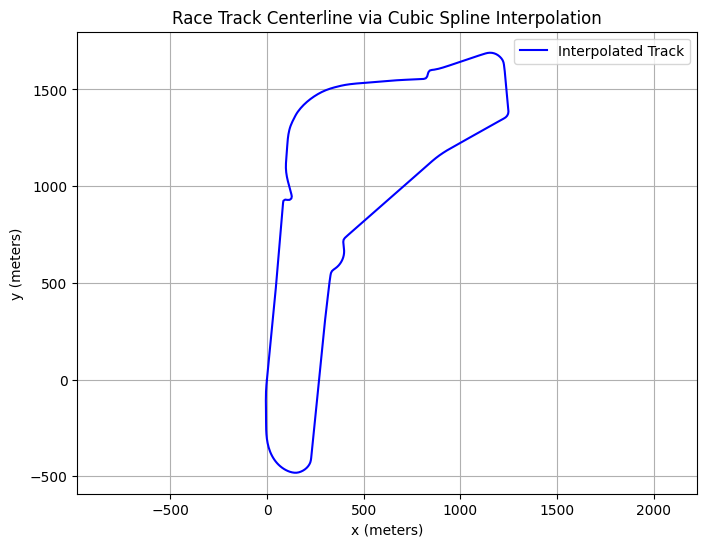

In [3]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)

In [6]:
# ======================================================================
# ============ V10: THE ROBUST RAY-FAN SCANNING ENGINE ===============
# ======================================================================

# --- Parameters for the new robust method ---
CURV_MIN      = 1e-4         # Threshold to treat a section as straight
DENSE_STEP    = 1.0          # 1 meter resolution is sufficient
DELTA_S       = 300.0        # Max look-ahead distance
SLIDING_WIN   = 60.0         # Sliding window for smoothing the final result

def build_boundaries(spline_x, spline_y, w_left, w_right, s_dense, s_orig):
    """Generates dense coordinates for left and right track boundaries."""
    xc, yc = spline_x(s_dense), spline_y(s_dense)
    dx, dy = spline_x.derivative(1)(s_dense), spline_y.derivative(1)(s_dense)
    norm_t = np.hypot(dx, dy)
    nx, ny = -dy / norm_t, dx / norm_t
    w_left_d  = np.interp(s_dense, s_orig, w_left)
    w_right_d = np.interp(s_dense, s_orig, w_right)
    return (xc + nx * w_left_d, yc + ny * w_left_d), (xc - nx * w_right_d, yc - ny * w_right_d)

def first_crossing_robust(ray_origin: np.ndarray, ray_direction: np.ndarray,
                          line_x: np.ndarray, line_y: np.ndarray,
                          line_s_coords: np.ndarray) -> float:
    """A robust ray-segment intersection function."""
    min_s_intersect = np.inf
    for i in range(len(line_x) - 1):
        A = np.array([line_x[i], line_y[i]])
        B = np.array([line_x[i+1], line_y[i+1]])
        v = B - A
        
        # Using a perpendicular dot product for the determinant
        M_det = ray_direction[0] * (-v[1]) - ray_direction[1] * (-v[0])
        if abs(M_det) < 1e-9: # Parallel lines
            continue

        rhs = A - ray_origin
        t = (rhs[0] * (-v[1]) - rhs[1] * (-v[0])) / M_det
        u = (ray_direction[0] * rhs[1] - ray_direction[1] * rhs[0]) / M_det

        if t > 1e-3 and 0.0 <= u <= 1.0:
            s_intersect = line_s_coords[i] + u * (line_s_coords[i+1] - line_s_coords[i])
            if s_intersect < min_s_intersect:
                min_s_intersect = s_intersect
    return min_s_intersect

def compute_fov_robust_scan(spline_x, spline_y,
                            w_left: np.ndarray, w_right: np.ndarray,
                            s_query: np.ndarray, s_orig: np.ndarray, s_max_val: float,
                            delta_s: float = DELTA_S,
                            step: float = DENSE_STEP):
    """Computes FOV using a simple and robust brute-force ray fan scan against boundaries."""
    s_dense = np.arange(0, s_max_val + step, step)
    (xl, yl), (xr, yr) = build_boundaries(spline_x, spline_y, w_left, w_right, s_dense, s_orig)
    sfov_raw = np.empty_like(s_query)
    
    # Define a fan of rays from -60 to +60 degrees, every 5 degrees
    ray_angles = np.deg2rad(np.arange(-60, 61, 5)) 

    dx_ds_func = spline_x.derivative(1)
    dy_ds_func = spline_y.derivative(1)

    for k, s0 in enumerate(s_query):
        s0_pos = np.array([spline_x(s0), spline_y(s0)])
        raw_dir_vec = np.array([dx_ds_func(s0), dy_ds_func(s0)])
        heading_vec = raw_dir_vec / np.linalg.norm(raw_dir_vec)
        
        # Define the forward window for this point
        idx0_s = np.searchsorted(s_dense, s0, side='left')
        idxw_s = np.searchsorted(s_dense, s0 + delta_s, side='right')
        
        # Create views into the dense arrays for the current window
        s_win = s_dense[idx0_s:idxw_s]
        xl_win, yl_win = xl[idx0_s:idxw_s], yl[idx0_s:idxw_s]
        xr_win, yr_win = xr[idx0_s:idxw_s], yr[idx0_s:idxw_s]

        min_s_overall = np.inf
        
        # For each ray in the fan...
        for angle in ray_angles:
            c, s = np.cos(angle), np.sin(angle)
            rot_matrix = np.array([[c, -s], [s, c]])
            ray_dir = rot_matrix @ heading_vec
            
            # ...find the first intersection with BOTH boundaries within the window
            s_left_intersect = first_crossing_robust(s0_pos, ray_dir, xl_win, yl_win, s_win)
            s_right_intersect = first_crossing_robust(s0_pos, ray_dir, xr_win, yr_win, s_win)
            
            # The closest intersection for this specific ray
            s_ray_min = min(s_left_intersect, s_right_intersect)
            
            # Keep track of the closest intersection among ALL rays
            if s_ray_min < min_s_overall:
                min_s_overall = s_ray_min
        
        sfov_raw[k] = min(min_s_overall, s0 + delta_s)

    win_samples = int(SLIDING_WIN / (s_query[1] - s_query[0])) if len(s_query) > 1 else 1
    sfov_series = pd.Series(sfov_raw)
    sfov_filt = sfov_series.rolling(window=win_samples, min_periods=1, center=True).min().to_numpy()
    
    return sfov_raw, sfov_filt

Starting FOV calculation with the ROBUST SCANNING algorithm (V10.1)...

Calculation complete. Visualizing results...


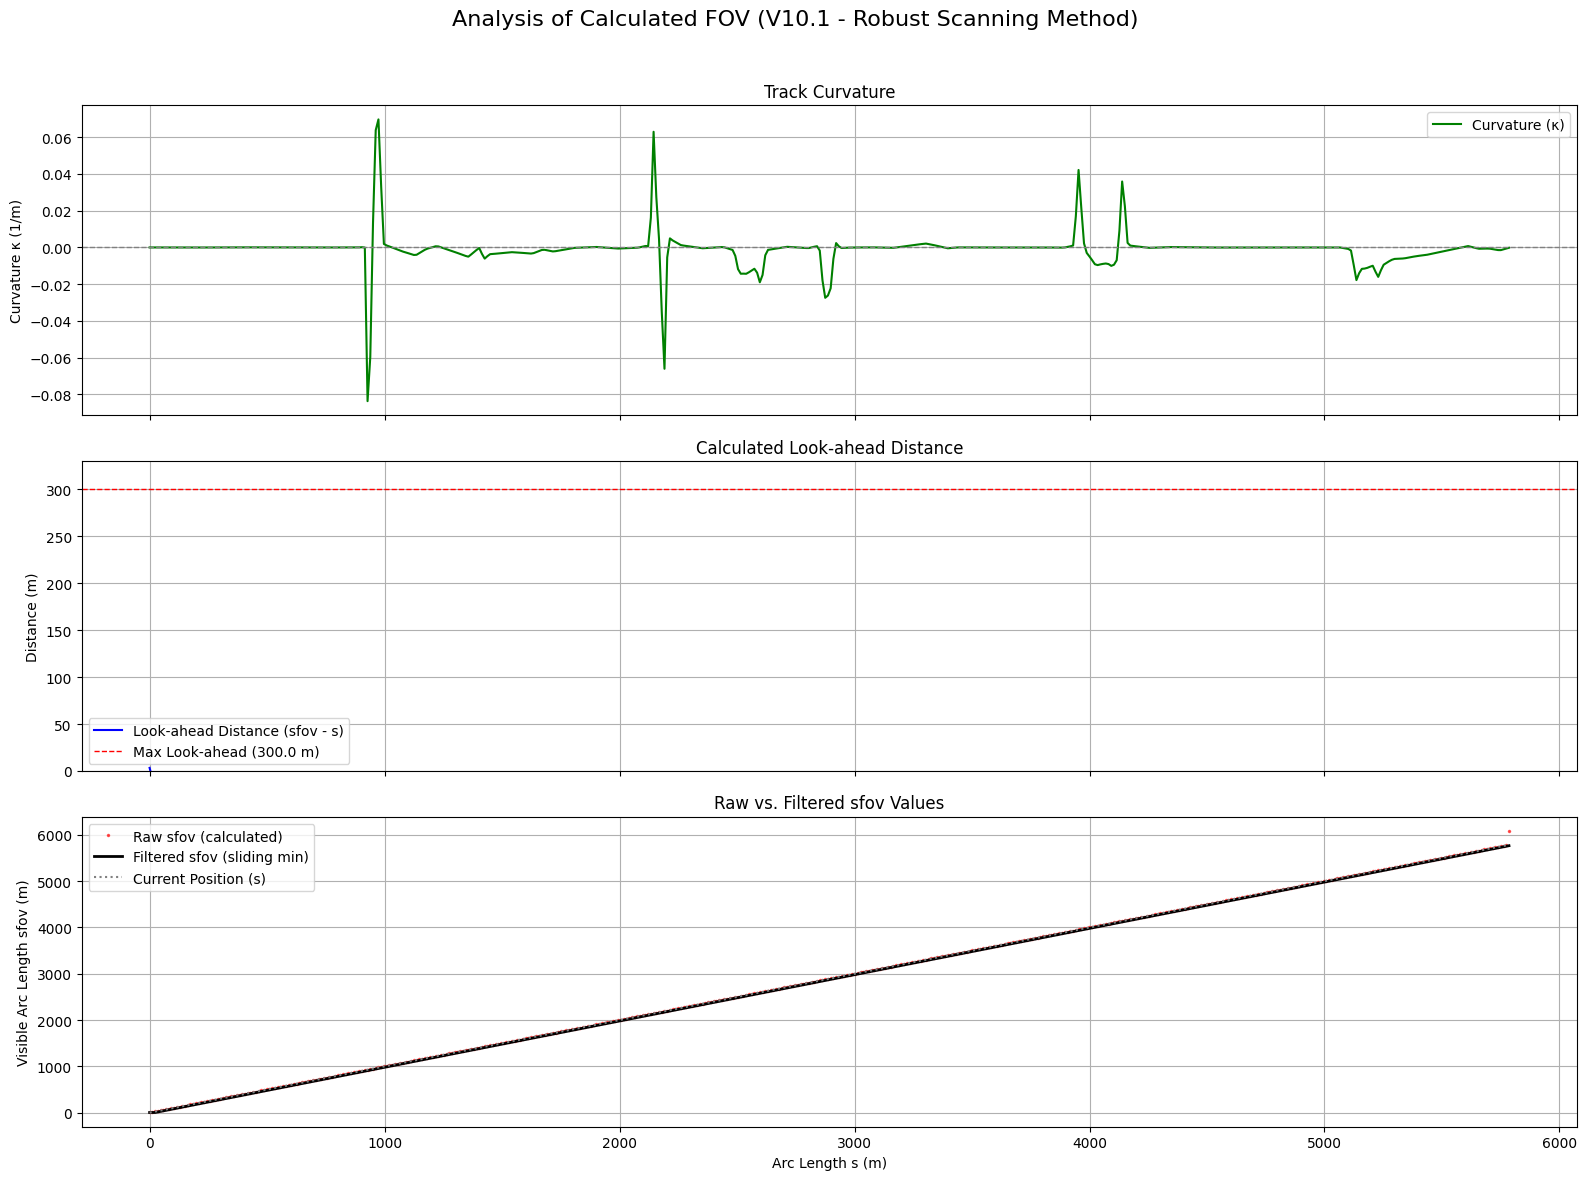

[INFO] sfov table saved to: /Users/yanxing.chen/SafeDrive25SS/Laptimeoptimization/Monza_sfov_V10.1_calculated.csv


In [9]:
'''
sfov_vals = compute_fov_all(
    x_spline, y_spline, w_left, w_right,
    s_query, delta_s=DELTA_S)

sfov_ca = ca.interpolant('sfov', 'linear', [s_query], sfov_vals)
'''
# THIS IS THE MISSING FUNCTION
def save_sfov_csv(s_samples, sfov_samples, in_csv_path: str, out_name: str = "sfov_lookup.csv"):
    df_out = pd.DataFrame({"s_m": s_samples, "sfov_m": sfov_samples})
    out_dir = os.path.dirname(os.path.abspath(in_csv_path)) if os.path.dirname(in_csv_path) else '.'
    full_path = os.path.join(out_dir, out_name)
    df_out.to_csv(full_path, index=False)
    print(f"[INFO] sfov table saved to: {full_path}")


s_query = np.linspace(0, s_max, 500)
print("Starting FOV calculation with the ROBUST SCANNING algorithm (V10.1)...")

sfov_raw_vals, sfov_filtered_vals = compute_fov_robust_scan(
    x_spline, y_spline, w_left, w_right, s_query, s, s_max
)

# _ = save_sfov_csv(s_query, sfov_filtered_vals, file_path, "Monza_sfov_V10.1_calculated.csv")

print("\nCalculation complete. Visualizing results...")

look_ahead_dist = sfov_filtered_vals - s_query
kappa_query = (dx_ds(s_query) * d2y_ds2(s_query) - dy_ds(s_query) * d2x_ds2(s_query))

fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Analysis of Calculated FOV (V10.1 - Robust Scanning Method)', fontsize=16)

axs[0].plot(s_query, kappa_query, color='green', label='Curvature (κ)')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[0].set_ylabel("Curvature κ (1/m)")
axs[0].set_title("Track Curvature")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(s_query, look_ahead_dist, color='blue', label='Look-ahead Distance (sfov - s)')
axs[1].axhline(DELTA_S, color='red', linestyle='--', linewidth=1, label=f'Max Look-ahead ({DELTA_S} m)')
axs[1].set_ylabel("Distance (m)")
axs[1].set_title("Calculated Look-ahead Distance")
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim(0, DELTA_S * 1.1)

axs[2].plot(s_query, sfov_raw_vals, 'r.', markersize=3, alpha=0.6, label='Raw sfov (calculated)')
axs[2].plot(s_query, sfov_filtered_vals, 'k-', linewidth=2, label='Filtered sfov (sliding min)')
axs[2].plot(s_query, s_query, ':', color='gray', linewidth=1.5, label='Current Position (s)')
axs[2].set_xlabel("Arc Length s (m)")
axs[2].set_ylabel("Visible Arc Length sfov (m)")
axs[2].set_title("Raw vs. Filtered sfov Values")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Since we can't save to ../ a temporary file will be created.
save_sfov_csv(s_query, sfov_filtered_vals, "../Laptimeoptimization/Monza.csv", "Monza_sfov_V10.1_calculated.csv")

In [9]:
# ---------- save_fov_to_csv.py ----------
import os
import pandas as pd

def save_sfov_csv(s_samples, sfov_samples,
                  in_csv_path: str,
                  out_name: str = "sfov_lookup.csv") -> str:
    """
    Save (s, sfov) pairs to a CSV file in the same folder as the input track.

    Parameters
    ----------
    s_samples     : 1-D array-like, arc-length samples.
    sfov_samples  : 1-D array-like, corresponding look-ahead values.
    in_csv_path   : str, path of the original track CSV (e.g. 'Monza.csv').
    out_name      : str, filename for the lookup table (default 'sfov_lookup.csv').

    Returns
    -------
    full_path     : str, absolute path of the written CSV file.
    """
    # build DataFrame
    df_out = pd.DataFrame({
        "s_m"   : s_samples,
        "sfov_m": sfov_samples
    })

    # decide output directory = same folder as input file
    out_dir = os.path.dirname(os.path.abspath(in_csv_path))
    full_path = os.path.join(out_dir, out_name)

    # write CSV (no index column)
    df_out.to_csv(full_path, index=False)
    print(f"[INFO] sfov table saved to: {full_path}")

    return full_path


# === example call ===
_ = save_sfov_csv(s_query, sfov_vals, file_path)

[INFO] sfov table saved to: /Users/yanxing.chen/SafeDrive25SS/Laptimeoptimization/sfov_lookup.csv


In [7]:
# ---------- sfov_interpolant.py ----------
from typing import Union, Callable
import numpy as np
from scipy.interpolate import CubicSpline

def build_sfov_interpolant(s_nodes: np.ndarray,
                           sfov_nodes: np.ndarray,
                           extrapolate: bool = True
                           ) -> Callable[[Union[float, np.ndarray]], np.ndarray]:
    """
    Create a C²-continuous cubic-spline interpolant sfov(s).

    Parameters
    ----------
    s_nodes     : 1-D ndarray, strictly increasing arc-length samples.
    sfov_nodes  : 1-D ndarray, same length, sfov at each sample.
    extrapolate : bool, default True, allow evaluation outside domain.

    Returns
    -------
    sfov_fun    : callable, use like  sfov_fun(s_eval)  →  sfov value(s).
    """
    # Natural BC: second derivative = 0 at both ends
    cs = CubicSpline(s_nodes, sfov_nodes,
                     bc_type="natural",
                     extrapolate=extrapolate)

    def sfov_fun(s_eval: Union[float, np.ndarray]) -> np.ndarray:
        """Vectorised wrapper around CubicSpline."""
        return cs(s_eval)

    return sfov_fun


# === example call & usage ===
sfov_fun = build_sfov_interpolant(s_query, sfov_vals)
print("sfov(123.4 m) =", float(sfov_fun(123.4)))

sfov(123.4 m) = 423.4


/var/folders/vw/l13tv5w120q5q88yj8hvhx4r0000gn/T/ipykernel_15821/48030074.py:51: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  car_dot.set_data(cx, cy)
/var/folders/vw/l13tv5w120q5q88yj8hvhx4r0000gn/T/ipykernel_15821/48030074.py:52: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  fov_dot.set_data(fx, fy)


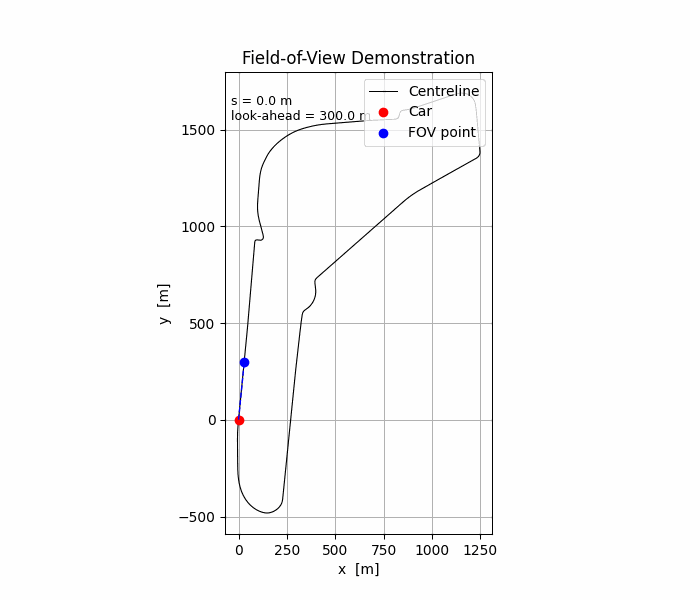

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display

# --------------------------------------------------------------
# sanity-check that required objects are in scope
for _name in ["x_spline", "y_spline", "sfov_fun", "s_max"]:
    if _name not in globals():
        raise RuntimeError(f"Define {_name} before running the animation cell")

# 1. pre-compute background
s_bg = np.linspace(0.0, s_max, 1200)
x_bg = x_spline(s_bg)
y_bg = y_spline(s_bg)

# 2. choose sample frames
n_frames = 400                       # 400 frames ≈ 20 s at 20 fps
s_frames = np.linspace(0.0, s_max, n_frames, endpoint=False)

car_xy  = np.column_stack((x_spline(s_frames),          y_spline(s_frames)))
fov_s   = sfov_fun(s_frames)
fov_xy  = np.column_stack((x_spline(fov_s),             y_spline(fov_s)))
look_ahead = fov_s - s_frames

# 3. build static figure
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(x_bg, y_bg, lw=0.8, color='k', label='Centreline')
car_dot, = ax.plot([], [], 'ro', ms=6, label='Car')
fov_dot, = ax.plot([], [], 'bo', ms=6, label='FOV point')
look_line, = ax.plot([], [], 'b--', lw=1.0)
txt = ax.text(0.02, 0.95, '', transform=ax.transAxes,
              fontsize=9, va='top')
ax.set_aspect('equal')
ax.set_title("Field-of-View Demonstration")
ax.legend(loc='upper right')
ax.set_xlabel('x  [m]')
ax.set_ylabel('y  [m]')
ax.grid(True)

def init():
    car_dot.set_data([], [])
    fov_dot.set_data([], [])
    look_line.set_data([], [])
    txt.set_text('')
    return car_dot, fov_dot, look_line, txt

def update(i):
    cx, cy = car_xy[i]
    fx, fy = fov_xy[i]
    car_dot.set_data(cx, cy)
    fov_dot.set_data(fx, fy)
    look_line.set_data([cx, fx], [cy, fy])
    txt.set_text(f's = {s_frames[i]:.1f} m\n'
                 f'look-ahead = {look_ahead[i]:.1f} m')
    return car_dot, fov_dot, look_line, txt

anim = FuncAnimation(fig, update, frames=n_frames,
                     init_func=init, blit=True, interval=50)

# 4. save as GIF and display
gif_path = "fov_demo.gif"
anim.save(gif_path, writer=PillowWriter(fps=20))
plt.close(fig)        # prevent duplicate static image

display(Image(filename=gif_path))

In [9]:
dbg = sfov_vals - s_query
idx = np.where(dbg < 2.0)[0]          # 找出 look-ahead < 2 m 的样本
print("suspect s =", s_query[idx])

suspect s = [ 939.08111704  950.67471108  962.26830512  973.86189916  985.45549319
  997.04908723 1008.64268127 1020.23627531 1055.01705742 1066.61065146
 1078.20424549 1089.79783953 1101.39143357 1112.98502761 1124.57862164
 1136.17221568 1147.76580972 1159.35940376 1170.95299779 1182.54659183
 1228.92096798 1275.29534413 1286.88893817 1298.48253221 1310.07612625
 1321.66972028 1333.26331432 1344.85690836 1356.4505024  1368.04409643
 1379.63769047 1391.23128451 1426.01206662 1437.60566066 1449.1992547
 1460.79284873 1472.38644277 1483.98003681 1495.57363085 1507.16722488
 1518.76081892 1530.35441296 1541.948007   1553.54160103 1565.13519507
 1576.72878911 1588.32238315 1599.91597718 1611.50957122 1623.10316526
 1634.6967593  1646.29035334 1657.88394737 1669.47754141 1681.07113545
 1692.66472949 1704.25832352 1715.85191756 1727.4455116  1739.03910564
 1750.63269967 1762.22629371 1994.09817446 2005.6917685  2121.62770888
 2133.22130291 2144.81489695 2156.40849099 2168.00208503 2179.5956

suspect s: [ 939.08111704  950.67471108  962.26830512  973.86189916  985.45549319
  997.04908723 1008.64268127 1020.23627531 1055.01705742 1066.61065146
 1078.20424549 1089.79783953 1101.39143357 1112.98502761 1124.57862164
 1136.17221568 1147.76580972 1159.35940376 1170.95299779 1182.54659183
 1228.92096798 1275.29534413 1286.88893817 1298.48253221 1310.07612625
 1321.66972028 1333.26331432 1344.85690836 1356.4505024  1368.04409643
 1379.63769047 1391.23128451 1426.01206662 1437.60566066 1449.1992547
 1460.79284873 1472.38644277 1483.98003681 1495.57363085 1507.16722488
 1518.76081892 1530.35441296 1541.948007   1553.54160103 1565.13519507
 1576.72878911 1588.32238315 1599.91597718 1611.50957122 1623.10316526
 1634.6967593  1646.29035334 1657.88394737 1669.47754141 1681.07113545
 1692.66472949 1704.25832352 1715.85191756 1727.4455116  1739.03910564
 1750.63269967 1762.22629371 1994.09817446 2005.6917685  2121.62770888
 2133.22130291 2144.81489695 2156.40849099 2168.00208503 2179.59567

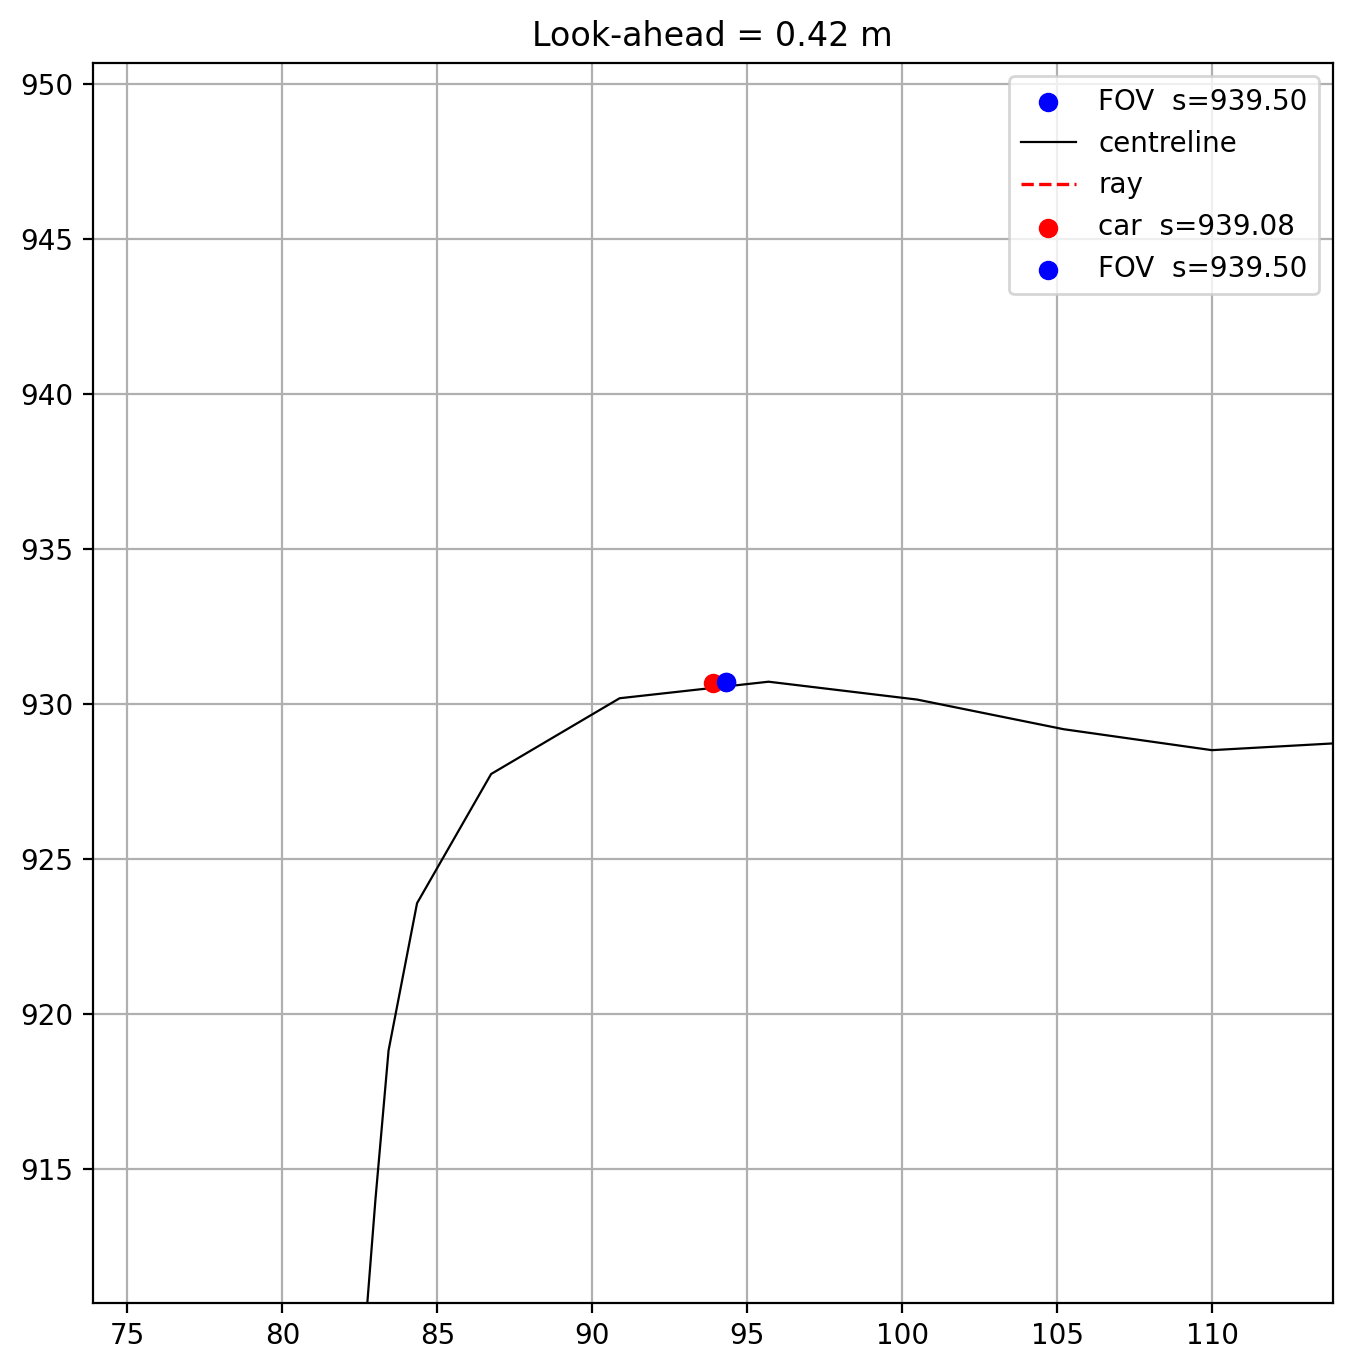

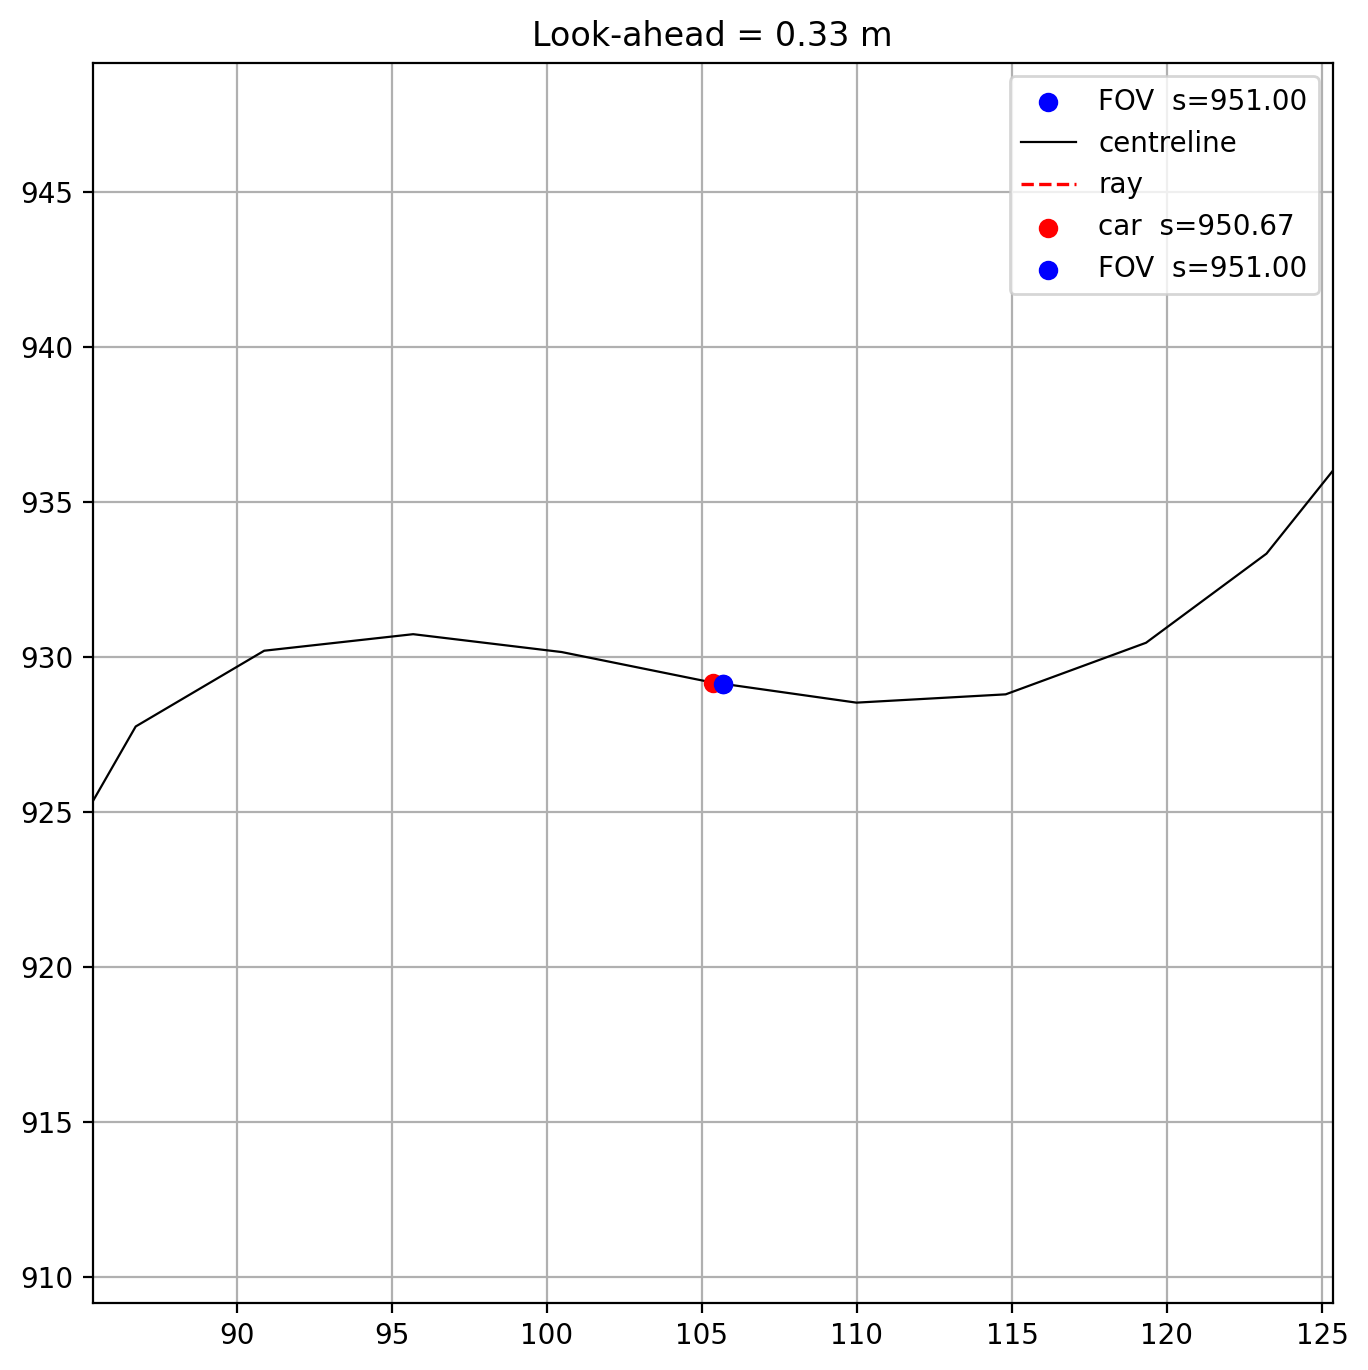

In [12]:
# ----------------------------------------------
# Visualise suspect look-ahead samples (< 2 m)
# ----------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

span = 40

# --------- 1. 找出异常样本 ---------------------
look_ahead = sfov_vals - s_query
suspect_idx = np.where(look_ahead < 2.0)[0]      # <—— 阈值可调
print("suspect s:", s_query[suspect_idx])

# 只挑前两个来画；你也可以手动指定 idx_list
idx_list = suspect_idx[:2]

# --------- 2. 预备背景（中心线 & 可选边界） -----
s_bg  = np.linspace(0, s_max, 1200)
x_bg  = x_spline(s_bg)
y_bg  = y_spline(s_bg)

# 若想同时画左右边界，取消下方注释
# w_left_bg  = np.interp(s_bg, s, w_left)
# w_right_bg = np.interp(s_bg, s, w_right)
# dx_bg = x_spline.derivative(1)(s_bg); dy_bg = y_spline.derivative(1)(s_bg)
# norm = np.hypot(dx_bg, dy_bg)
# nx_bg, ny_bg = -dy_bg / norm, dx_bg / norm
# xl_bg = x_bg + nx_bg * w_left_bg;  yl_bg = y_bg + ny_bg * w_left_bg
# xr_bg = x_bg - nx_bg * w_right_bg; yr_bg = y_bg - ny_bg * w_right_bg

for idx in idx_list:
    s0     = s_query[idx]
    s_fov  = sfov_vals[idx]

    # 车辆位置 / FOV 交点
    car_xy = np.array([x_spline(s0),     y_spline(s0)])
    fov_xy = np.array([x_spline(s_fov),  y_spline(s_fov)])

    # 车辆当前射线方向（只是用两个点连线即可）
    ray_vec = fov_xy - car_xy

    # --------- 3. 画图 -------------------------
    plt.figure(figsize=(8, 10), dpi=200)   # figsize 单位英寸, dpi 越大像素越多

    plt.scatter(*fov_xy, c='b', zorder=5, label=f'FOV  s={s_fov:.2f}')

    # ⬇⬇ 关键：限制坐标轴到车辆 ±span/2 ⬇⬇
    plt.xlim(car_xy[0] - span/2, car_xy[0] + span/2)
    plt.ylim(car_xy[1] - span/2, car_xy[1] + span/2)

    plt.gca().set_aspect('equal')


    plt.plot(x_bg, y_bg, 'k', lw=0.8, label='centreline')

    # 如需边界，取消注释
    # plt.plot(xl_bg, yl_bg, '0.7', lw=0.5)
    # plt.plot(xr_bg, yr_bg, '0.7', lw=0.5)

    plt.plot([car_xy[0], fov_xy[0]], [car_xy[1], fov_xy[1]],
             'r--', lw=1.2, label='ray')
    plt.scatter(*car_xy, c='r', zorder=5, label=f'car  s={s0:.2f}')
    plt.scatter(*fov_xy, c='b', zorder=5, label=f'FOV  s={s_fov:.2f}')

    plt.gca().set_aspect('equal')
    plt.title(f'Look-ahead = {s_fov - s0:.2f} m')
    plt.legend()
    plt.grid(True)
    plt.show()